# Clustering Analysis Report: Anuran Calls Dataset (MFCCs)

## 1. Importing Necessary Libraries

In [8]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

## 2. Load the Dataset
**Feature and Label Separation:**
- The `features` variable is created to contain only the numeric columns from the dataset. These numeric columns represent the Mel-Frequency Cepstral Coefficients (MFCCs), which are crucial for the clustering process as they capture the characteristics of the frog calls.
- The `labels` variable is generated to hold the categorical columns (e.g., Family, Genus, Species). These labels are important for understanding the context of the data but are not used directly in the clustering algorithms.

In [9]:
# Load the dataset
data = pd.read_csv("Frogs_MFCCs.csv")  # Replace with your dataset path

# Separate numeric features and categorical labels
features = data.select_dtypes(include=[np.number])  # Numeric data for clustering
labels = data.select_dtypes(exclude=[np.number])    # Labels for reference, not used in clustering

### Overview of Dataset
- The `data.info()` method is called to provide a summary of the dataset's structure. This includes details about the number of entries, the column names, the data types of each column, and the presence of any missing values. This overview is essential for gaining initial insights into the dataset and understanding its composition.

### Missing Values Analysis
- The `data.isnull().sum()` function is used to check for missing values in each column of the dataset. This step is crucial for data cleaning, as missing values can adversely affect the performance of clustering algorithms and lead to biased results.

### Visualizing Feature Distributions
- A histogram is created using `features.hist(bins=25, figsize=(14, 8), edgecolor='grey')` to visualize the distribution of each numeric feature. This visualization helps to identify the spread and potential skewness in the data.

### Outlier Detection
- A boxplot is generated with `sns.boxplot(data=features, orient="h", palette="coolwarm")` to visualize outliers in the numeric features. Outliers can significantly influence clustering results, so identifying them is an important step.


Overview of Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7195 entries, 0 to 7194
Data columns (total 26 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   MFCCs_ 1  7195 non-null   float64
 1   MFCCs_ 2  7195 non-null   float64
 2   MFCCs_ 3  7195 non-null   float64
 3   MFCCs_ 4  7195 non-null   float64
 4   MFCCs_ 5  7195 non-null   float64
 5   MFCCs_ 6  7195 non-null   float64
 6   MFCCs_ 7  7195 non-null   float64
 7   MFCCs_ 8  7195 non-null   float64
 8   MFCCs_ 9  7195 non-null   float64
 9   MFCCs_10  7195 non-null   float64
 10  MFCCs_11  7195 non-null   float64
 11  MFCCs_12  7195 non-null   float64
 12  MFCCs_13  7195 non-null   float64
 13  MFCCs_14  7195 non-null   float64
 14  MFCCs_15  7195 non-null   float64
 15  MFCCs_16  7195 non-null   float64
 16  MFCCs_17  7195 non-null   float64
 17  MFCCs_18  7195 non-null   float64
 18  MFCCs_19  7195 non-null   float64
 19  MFCCs_20  7195 non-null   float64
 20  MFCCs_21 

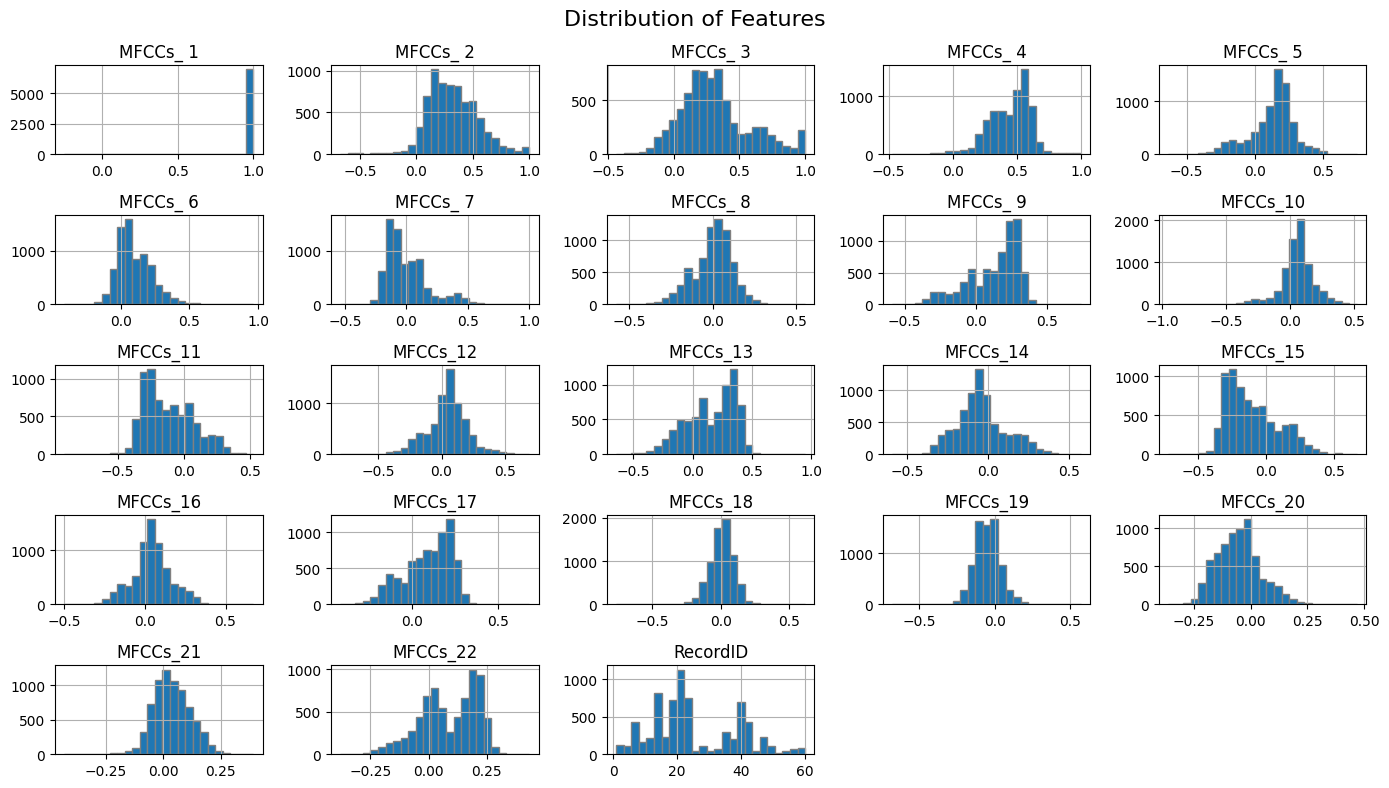

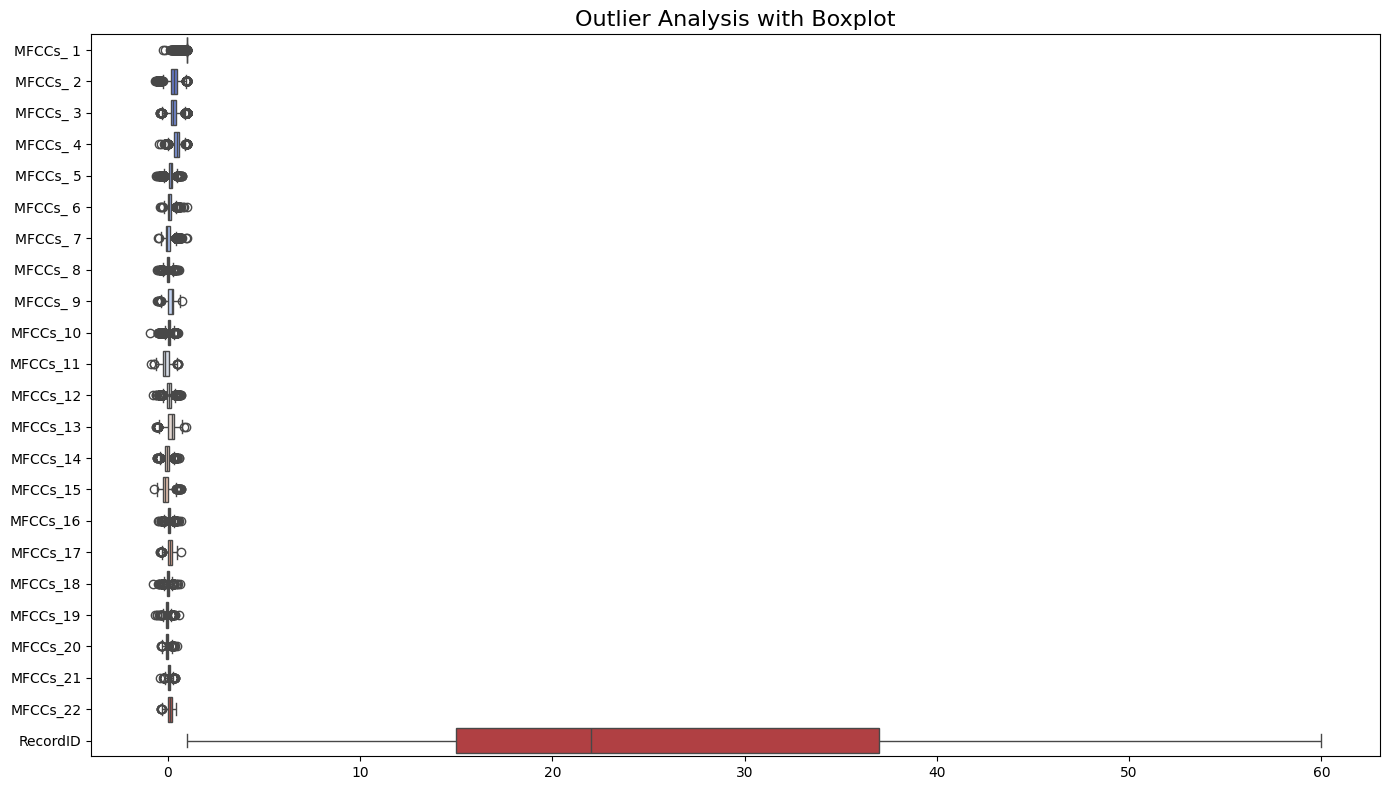

In [10]:
# Display dataset overview
print("Overview of Dataset:")
print(data.info())

# Examine missing values
print("\nMissing Values Per Column:")
print(data.isnull().sum())

# Visualize distributions of numeric columns
features.hist(bins=25, figsize=(14, 8), edgecolor='grey')
plt.suptitle("Distribution of Features", fontsize=16)
plt.tight_layout()
plt.show()

# Detect outliers with boxplot
plt.figure(figsize=(14, 8))
sns.boxplot(data=features, orient="h", palette="coolwarm")
plt.title("Outlier Analysis with Boxplot", fontsize=16)
plt.tight_layout()
plt.show()

## Data Scaling
- The `StandardScaler` from `sklearn.preprocessing` is used to standardize the features. Standardization is important as it transforms the features to have a mean of 0 and a standard deviation of 1, ensuring that all features contribute equally to the clustering process.


In [11]:
# 1.2 Data Scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

## Feature Engineering
- The `PolynomialFeatures` class from `sklearn.preprocessing` is utilized to create interaction terms and polynomial features. This step potentially enhances the clustering performance by introducing new features that capture interactions between the original MFCC coefficients. The original number of features is compared with the number of engineered features.

In [12]:
# 1.3 Feature Engineering
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
enhanced_features = poly.fit_transform(scaled_features)
print(f"Original Features: {scaled_features.shape[1]}, Features After Engineering: {enhanced_features.shape[1]}")

Original Features: 23, Features After Engineering: 276


## Feature Correlation Analysis
- A correlation matrix is generated with `np.corrcoef(scaled_features, rowvar=False)` to investigate the correlations between features. This analysis helps in identifying highly correlated features that may introduce redundancy in the dataset.
- A heatmap visualizes the correlation matrix using `sns.heatmap()`, making it easier to spot correlations visually.

### Removal of Highly Correlated Features
- A loop is implemented to identify and print pairs of highly correlated features (with a correlation greater than 0.9). These features are subsequently removed to ensure the remaining features are not redundant.
- The number of features after this reduction is displayed to understand the impact of this cleaning process.


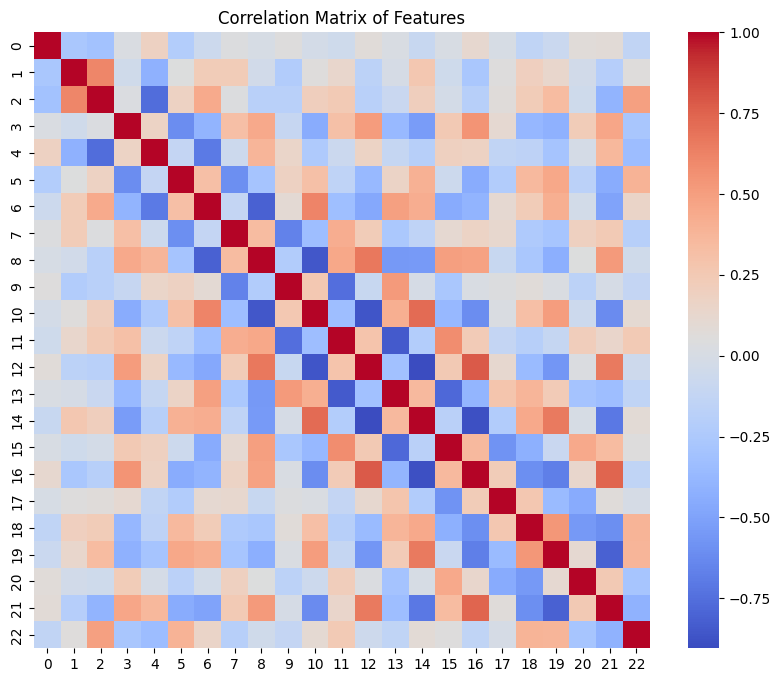

Highly Correlated Pair: Feature 14 and Feature 12 with correlation of -0.90
Number of Features After Reduction: 22


In [13]:
# 1.4 Feature Correlation Analysis
corr_matrix = np.corrcoef(scaled_features, rowvar=False)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", square=True)
plt.title("Correlation Matrix of Features")
plt.show()

# Identify and remove highly correlated features (threshold > 0.9)
correlated_features = set()
threshold = 0.9
for i in range(1, len(corr_matrix)):
    highly_corr = [(j, corr_matrix[i, j]) for j in range(i) if abs(corr_matrix[i, j]) > threshold]
    for j, corr_value in highly_corr:
        print(f"Highly Correlated Pair: Feature {i} and Feature {j} with correlation of {corr_value:.2f}")
        correlated_features.add(i)

# Keep only the non-correlated features
features_reduced = np.delete(scaled_features, list(correlated_features), axis=1)
print(f"Number of Features After Reduction: {features_reduced.shape[1]}")

# K-Means Clustering

## Elbow Method
- The Elbow Method is implemented by iterating through a range of cluster numbers (1 to 10) and fitting a K-Means model for each cluster count. The inertia (sum of squared distances from each point to its assigned cluster center) is recorded for each model.
- A plot is generated to visualize the inertia values against the number of clusters. The 'elbow' point in this plot helps to determine the optimal number of clusters.

## Silhouette Score Evaluation
- The silhouette score is calculated for a range of clusters (2 to 10) to evaluate the quality of clustering. The silhouette score measures how similar an object is to its own cluster compared to other clusters.
- A plot is created to visualize silhouette scores against the number of clusters, aiding in the determination of the optimal number of clusters based on the highest silhouette score.

## K-Means Clustering Implementation
- The optimal number of clusters, determined from the silhouette score evaluation, is used to fit the K-Means clustering model on the reduced feature set. The cluster labels are obtained for further analysis.


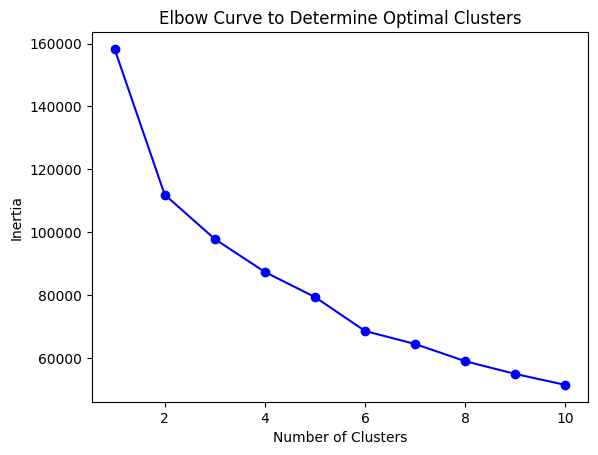

In [14]:
# 2. K-Means Clustering

# 2.1 Elbow Method
inertia_values = []
cluster_range = range(1, 11)

for clusters in cluster_range:
    kmeans = KMeans(n_clusters=clusters, random_state=71)
    kmeans.fit(features_reduced)
    inertia_values.append(kmeans.inertia_)

# Plotting the Elbow Curve
plt.plot(cluster_range, inertia_values, 'bo-')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Curve to Determine Optimal Clusters")
plt.show()

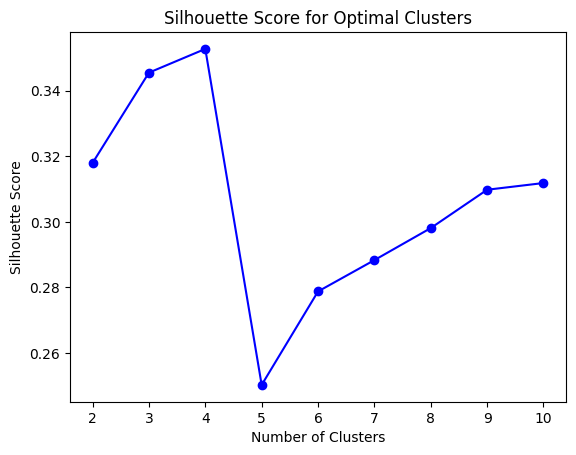

Optimal Number of Clusters (Silhouette): 4


In [15]:
# 2.2 Silhouette Score Evaluation
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=71)
    labels = kmeans.fit_predict(features_reduced)
    silhouette_scores.append(silhouette_score(features_reduced, labels))

plt.plot(range(2, 11), silhouette_scores, 'bo-')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Optimal Clusters")
plt.show()

# Optimal number of clusters based on silhouette score
optimal_k_silhouette = np.argmax(silhouette_scores) + 2
print(f"Optimal Number of Clusters (Silhouette): {optimal_k_silhouette}")

In [16]:
# 2.3 K-Means Clustering Implementation
optimal_k = optimal_k_silhouette
kmeans = KMeans(n_clusters=optimal_k, random_state=71)
cluster_labels = kmeans.fit_predict(features_reduced)


## Comparing Cluster Initialization Methods
- K-Means clustering is applied using two different initialization methods: 'random' and 'k-means++'. 
- The inertia values for both methods are calculated and displayed, providing insights into the efficiency of each initialization approach.


In [17]:
# 2.4 Comparing Cluster Initialization Methods
# Using 'random' initialization for k-means clustering
kmeans_random = KMeans(n_clusters=optimal_k, init='random', random_state=42)
kmeans_random.fit(features_reduced)
inertia_random = kmeans_random.inertia_

# Using 'k-means++' initialization for k-means clustering
kmeans_plus = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
kmeans_plus.fit(features_reduced)
inertia_plus = kmeans_plus.inertia_

# Creating a dictionary to store the results
inertia_results = {
    "random initialization": inertia_random,
    "k-means++ initialization": inertia_plus
}

# Displaying the results of the comparison using a loop with 4 decimal rounding
print("Comparison of Cluster Initialization Methods:")
for init_method, inertia in inertia_results.items():
    print(f"Inertia with {init_method}: {round(inertia, 4)}")

Comparison of Cluster Initialization Methods:
Inertia with random initialization: 86464.5662
Inertia with k-means++ initialization: 87213.4854


# Cluster Visualization

## Dimensionality Reduction
- PCA (Principal Component Analysis) is applied to reduce the dimensionality of the feature set for visualization purposes. The `PCA` model is fitted and transformed to two components for easier interpretation.

## Cluster Plots
- A scatter plot is created to visualize the K-Means clusters in the reduced 2D PCA space. Each point is colored according to its cluster label, making it easy to observe the separation between clusters.


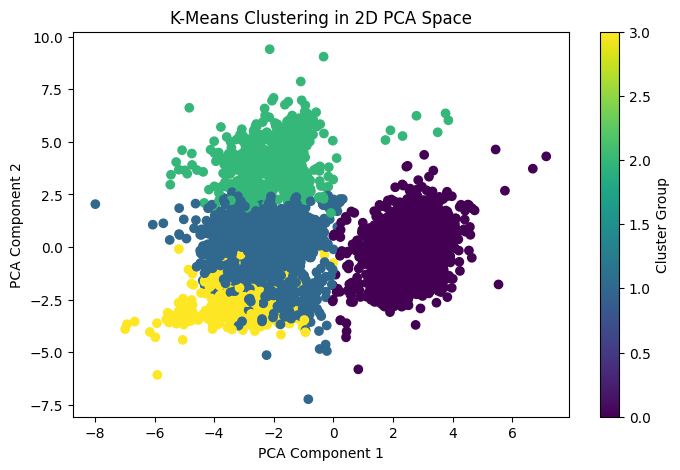

In [18]:
# 3. Cluster Visualization

# 3.1 Applying PCA for Dimensionality Reduction
pca_model = PCA(n_components=2)
pca_transformed_features = pca_model.fit_transform(features_reduced)

# Scatter plot showing K-Means clusters in 2D space after PCA reduction
plt.figure(figsize=(8, 5))
plt.scatter(pca_transformed_features[:, 0], pca_transformed_features[:, 1], c=cluster_labels, cmap='viridis')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("K-Means Clustering in 2D PCA Space")
plt.colorbar(label='Cluster Group')
plt.show()

## Feature Contribution to Clustering
- A heatmap visualizes the contribution of original features to each PCA component, allowing analysis of which features most significantly influence the clustering outcomes.


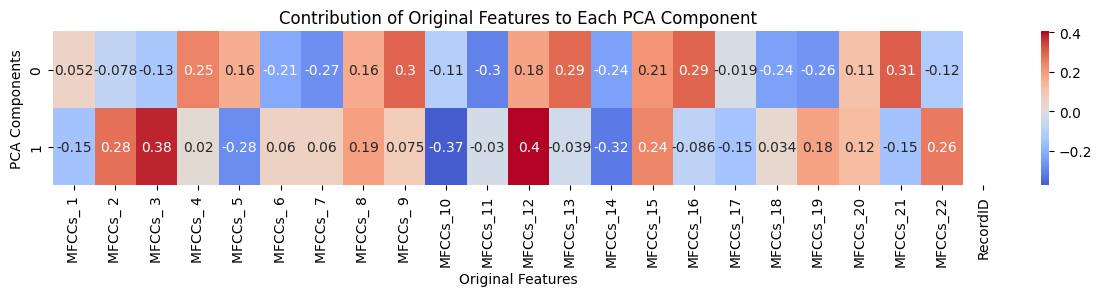

In [19]:
# 3.2 Feature Contribution to Clustering
plt.figure(figsize=(15, 2))
sns.heatmap(pca_model.components_, annot=True, cmap='coolwarm', xticklabels=features.columns, center=0)
plt.xlabel("Original Features")
plt.ylabel("PCA Components")
plt.title("Contribution of Original Features to Each PCA Component")
plt.show()


# Cluster Evaluation Metrics

## Evaluation Using Multiple Metrics
- The Davies-Bouldin Index and Calinski-Harabasz Index are calculated for a range of cluster numbers. These metrics provide additional insights into the clustering quality beyond the silhouette score.
- The results are stored in a DataFrame for easy inspection and comparison.


Cluster Evaluation Metrics Matrix:
   Number of Clusters  Davies-Bouldin Index  Calinski-Harabasz Index
0                   2              1.373738              2977.428712
1                   3              1.520733              2069.419339
2                   4              1.556521              1953.488839
3                   5              1.344466              1918.245699
4                   6              1.497531              1692.506050
5                   7              1.503695              1725.564637
6                   8              1.591758              1577.602155
7                   9              1.552163              1521.234869
8                  10              1.503413              1535.120139


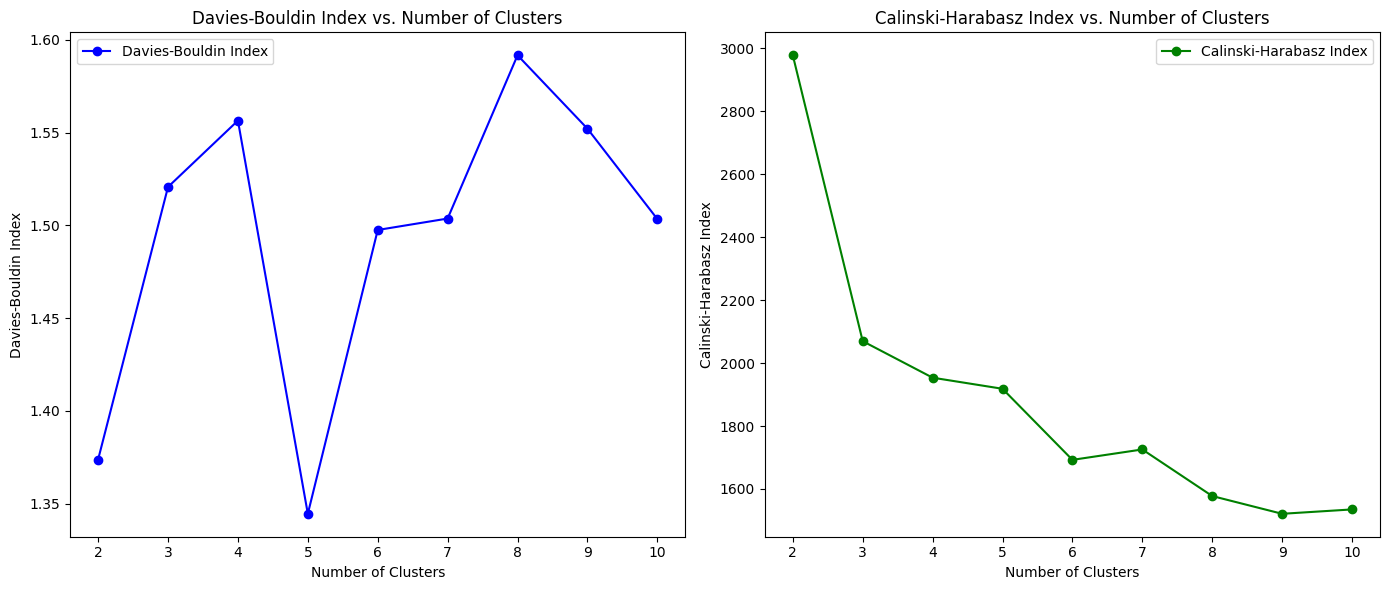

In [20]:
# 4. Cluster Evaluation Metrics

# Function to calculate evaluation metrics for a range of cluster numbers
def calculate_metrics(features, cluster_range):
    db_scores = []
    ch_scores = []
    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(features)
        db_scores.append(davies_bouldin_score(features, labels))
        ch_scores.append(calinski_harabasz_score(features, labels))
    return db_scores, ch_scores

# Function to plot evaluation metrics
def plot_metrics(cluster_range, db_scores, ch_scores):
    plt.figure(figsize=(14, 6))

    # Plotting Davies-Bouldin Index
    plt.subplot(1, 2, 1)
    plt.plot(cluster_range, db_scores, 'bo-', label="Davies-Bouldin Index")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Davies-Bouldin Index")
    plt.title("Davies-Bouldin Index vs. Number of Clusters")
    plt.legend()

    # Plotting Calinski-Harabasz Index
    plt.subplot(1, 2, 2)
    plt.plot(cluster_range, ch_scores, 'go-', label="Calinski-Harabasz Index")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Calinski-Harabasz Index")
    plt.title("Calinski-Harabasz Index vs. Number of Clusters")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Define the range of clusters to evaluate
cluster_range = range(2, 11)

# Calculate Davies-Bouldin and Calinski-Harabasz scores
db_scores, ch_scores = calculate_metrics(features_reduced, cluster_range)

# Store metrics in a DataFrame for easy inspection
evaluation_metrics = pd.DataFrame({
    "Number of Clusters": list(cluster_range),
    "Davies-Bouldin Index": db_scores,
    "Calinski-Harabasz Index": ch_scores
})

print("Cluster Evaluation Metrics Matrix:")
print(evaluation_metrics)

# Plot the metrics for comparison
plot_metrics(cluster_range, db_scores, ch_scores)

# Comparison with Other Clustering Algorithms

## Algorithm Comparison
- K-Means, Agglomerative Hierarchical Clustering, and DBSCAN are applied to the dataset. The resulting cluster labels from each method are obtained for comparison.
- Visualization of clustering results for each algorithm is done using scatter plots, allowing for visual comparison of clustering patterns across methods.


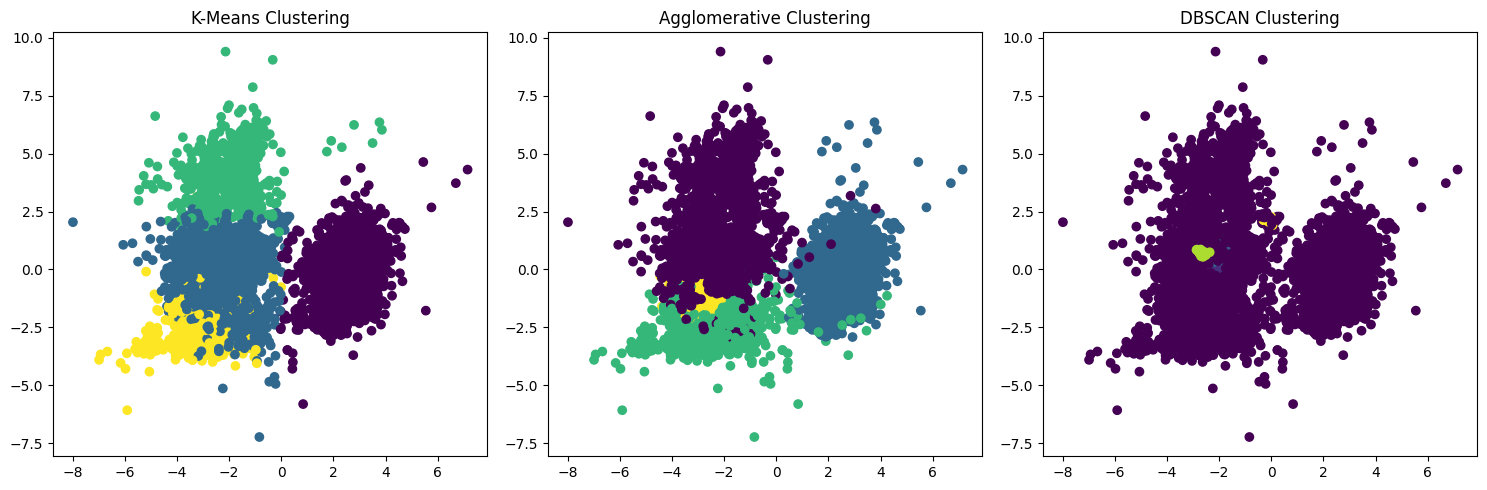

In [21]:
# 5. Comparison with Other Clustering Algorithms

# Apply K-Means, Agglomerative, and DBSCAN
kmeans_labels = KMeans(n_clusters=optimal_k, random_state=71).fit_predict(features_reduced)
agglo_labels = AgglomerativeClustering(n_clusters=optimal_k).fit_predict(features_reduced)
dbscan_labels = DBSCAN(eps=0.5, min_samples=5).fit_predict(features_reduced)

# Visualization of clustering results
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(pca_transformed_features[:, 0], pca_transformed_features[:, 1], c=kmeans_labels, cmap='viridis')
plt.title("K-Means Clustering")

plt.subplot(1, 3, 2)
plt.scatter(pca_transformed_features[:, 0], pca_transformed_features[:, 1], c=agglo_labels, cmap='viridis')
plt.title("Agglomerative Clustering")

plt.subplot(1, 3, 3)
plt.scatter(pca_transformed_features[:, 0], pca_transformed_features[:, 1], c=dbscan_labels, cmap='viridis')
plt.title("DBSCAN Clustering")

plt.tight_layout()
plt.show()


# Analysis and Report
- The overall clustering process is summarized, highlighting the optimal number of clusters found, insights from visualizations, and analyses of the evaluation metrics.
- Limitations of K-Means and other clustering algorithms are discussed, particularly in relation to their applicability to the Anuran Calls dataset.

In [22]:
# 6. Analysis and Comparison of Clustering Algorithms

print("\n--- Clustering Algorithm Analysis ---")
print("\nK-Means Clustering:")
print("Pros: Efficient on large datasets, works well with spherical clusters.")
print("Cons: Assumes clusters are spherical, sensitive to initial centroids.")

print("\nAgglomerative Clustering:")
print("Pros: Can capture clusters of various shapes, suitable for small datasets.")
print("Cons: Computationally expensive, hard to scale, not effective with noise.")

print("\nDBSCAN Clustering:")
print("Pros: Identifies clusters of arbitrary shapes, handles noise well.")
print("Cons: Sensitive to parameter tuning, struggles with clusters of varying density.")
print("\nIn conclusion, each algorithm has unique strengths and is suitable depending on dataset structure and clustering goals.")


--- Clustering Algorithm Analysis ---

K-Means Clustering:
Pros: Efficient on large datasets, works well with spherical clusters.
Cons: Assumes clusters are spherical, sensitive to initial centroids.

Agglomerative Clustering:
Pros: Can capture clusters of various shapes, suitable for small datasets.
Cons: Computationally expensive, hard to scale, not effective with noise.

DBSCAN Clustering:
Pros: Identifies clusters of arbitrary shapes, handles noise well.
Cons: Sensitive to parameter tuning, struggles with clusters of varying density.

In conclusion, each algorithm has unique strengths and is suitable depending on dataset structure and clustering goals.
